In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [3]:
# 1. 데이터 로드 및 전처리

cols = [
    'sample_index',
    'user_id',
    'activity',
    'timestamp',
    'x_accel',
    'y_accel',
    'z_accel'
]

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WISDM.csv', header=None, names=cols)

In [6]:
df

,sample_index,user_id,activity,timestamp,x_accel,y_accel,z_accel
0,0,33,Jogging,4.910600e+13,-0.694638,12.680544,0.503953
1,1,33,Jogging,4.910610e+13,5.012288,11.264028,0.953424
2,2,33,Jogging,4.910610e+13,4.903325,10.882658,-0.081722
3,3,33,Jogging,4.910620e+13,-0.612916,18.496431,3.023717
4,4,33,Jogging,4.910630e+13,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...,...
1048570,1048571,7,Standing,2.091650e+14,-7.930000,5.430000,-0.990000
1048571,1048572,7,Standing,2.091660e+14,-7.970000,5.130000,-1.140000
1048572,1048573,7,Standing,2.091660e+14,-7.970000,5.220000,-1.380000
1048573,1048574,7,Standing,2.091660e+14,-7.930000,5.600000,-1.180000


In [45]:
df['activity'].value_counts()

,count
activity,
Walking,406775
Jogging,325975
Upstairs,118589
Downstairs,97813
Sitting,54876
Standing,44547


In [7]:
df.shape

(1048575, 7)

In [8]:
df.isnull().values.any()

np.False_

In [10]:
features = ['x_accel', 'y_accel', 'z_accel']
LABELS = ["Jogging", "Not Jogging"] # 레이블 이름 변경
df['Class'] = df['activity'].apply(lambda x: 0 if x == 'Jogging' else 1)
data = df[features + ['Class']]

/tmp/ipython-input-2289644155.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


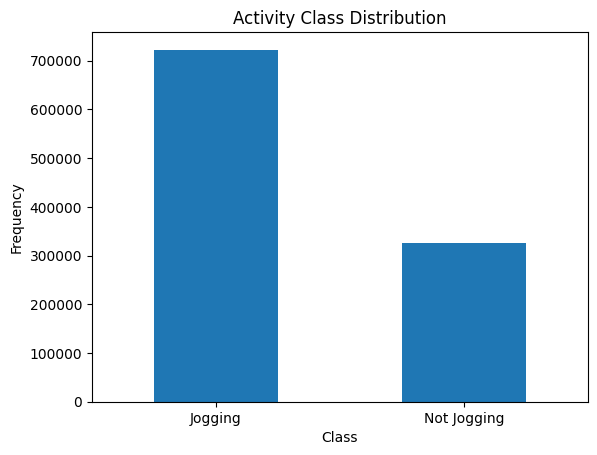

In [13]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Activity Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [11]:
jogging = df[df.Class == 0]
not_jogging = df[df.Class == 1]
jogging.shape

(325975, 8)

In [12]:
not_jogging.shape

(722600, 8)

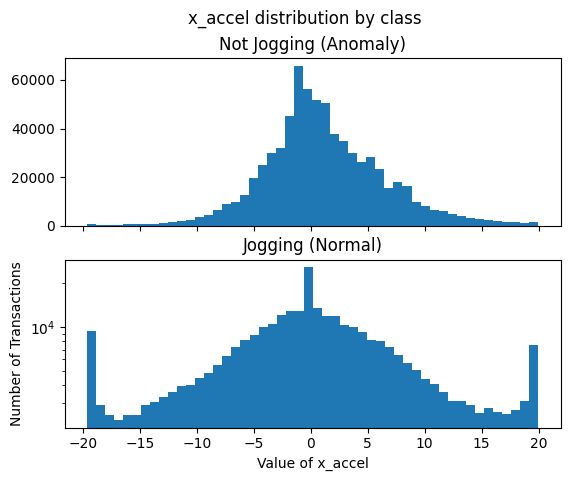

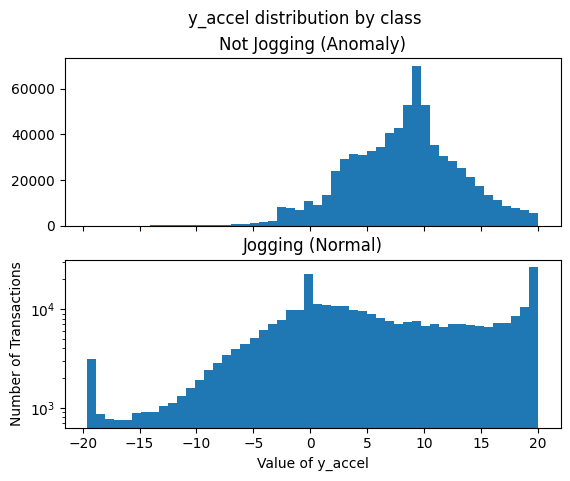

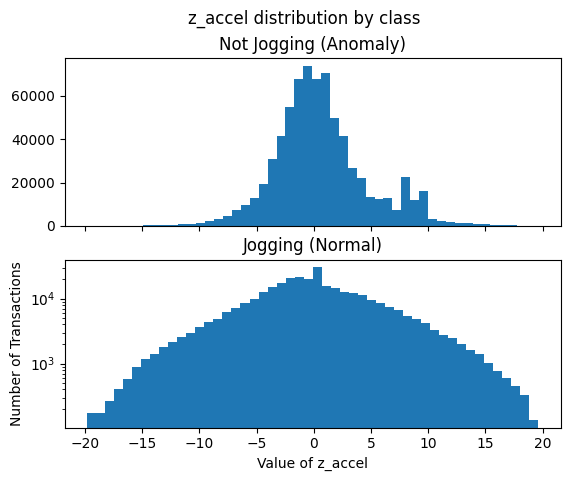

In [14]:
for feature in features:
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    f.suptitle(f'{feature} distribution by class')

    bins = 50
    ax1.hist(not_jogging[feature], bins=bins)
    ax1.set_title('Not Jogging (Anomaly)')

    ax2.hist(jogging[feature], bins=bins)
    ax2.set_title('Jogging (Normal)')

    plt.xlabel(f'Value of {feature}')
    plt.ylabel('Number of Transactions')
    plt.yscale('log') # 데이터가 한쪽에 몰려있을 수 있으므로 log scale 사용
    plt.show()

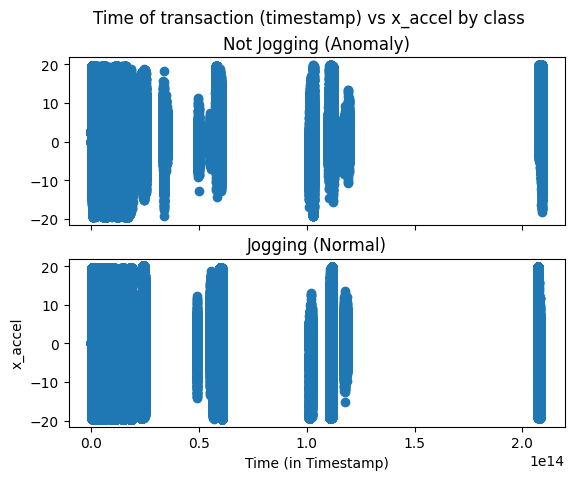

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction (timestamp) vs x_accel by class')

ax1.scatter(not_jogging.timestamp, not_jogging.x_accel)
ax1.set_title('Not Jogging (Anomaly)')

ax2.scatter(jogging.timestamp, jogging.x_accel)
ax2.set_title('Jogging (Normal)')

plt.xlabel('Time (in Timestamp)')
plt.ylabel('x_accel')
plt.show()

In [28]:
from sklearn.preprocessing import StandardScaler

RANDOM_SEED = 42
data_df = df[features + ['Class']]

X_train_df, X_test_df = train_test_split(data_df, test_size=0.2, random_state=RANDOM_SEED)

X_train = X_train_df[X_train_df.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test_df['Class']
X_test = X_test_df.drop(['Class'], axis=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [46]:
input_dim = X_train.shape[1] # 3
encoding_dim_1 = 16
encoding_dim_2 = 8
encoding_dim_3 = 2  # Bottleneck

input_layer = Input(shape=(input_dim,))
# 인코더 (3 -> 16 -> 8 -> 2)
encoded = Dense(encoding_dim_1, activation='relu')(input_layer)
encoded = Dense(encoding_dim_2, activation='relu')(encoded)
encoded = Dense(encoding_dim_3, activation='relu')(encoded) # Bottleneck (2)
# 디코더 (2 -> 8 -> 16 -> 3)
decoded = Dense(encoding_dim_2, activation='relu')(encoded)
decoded = Dense(encoding_dim_1, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded) # 마지막은 'linear' (중요)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history = autoencoder.fit(X_train, X_train,
                          epochs=100, # 50 -> 100
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.1,
                          verbose=1)

Epoch 1/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5258 - val_loss: 0.1935
Epoch 2/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1789 - val_loss: 0.1382
Epoch 3/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1322 - val_loss: 0.1180
Epoch 4/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1147 - val_loss: 0.1059
Epoch 5/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1061 - val_loss: 0.1021
Epoch 6/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1024 - val_loss: 0.0995
Epoch 7/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0998 - val_loss: 0.0965
Epoch 8/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0972 - val_loss: 0.0972
Epoch 9/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0971 - val_loss: 0.0952
Epoch 10/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0951 - val_loss: 0.0934
Epoch 11/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0940 - val_loss: 0.0922
Epoch 12/100
917/917 ━━━━━━━━━━━━━━━━━━━━

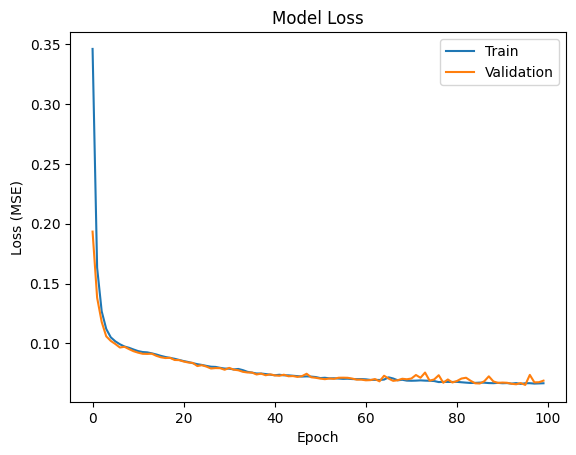

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [49]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

error_df.describe()

6554/6554 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


,reconstruction_error,true_class
count,209715.000000,209715.000000
mean,0.070413,0.688587
std,0.099345,0.463072
min,0.000017,0.000000
25%,0.014904,0.000000
50%,0.050466,1.000000
75%,0.102085,1.000000
max,6.234198,1.000000


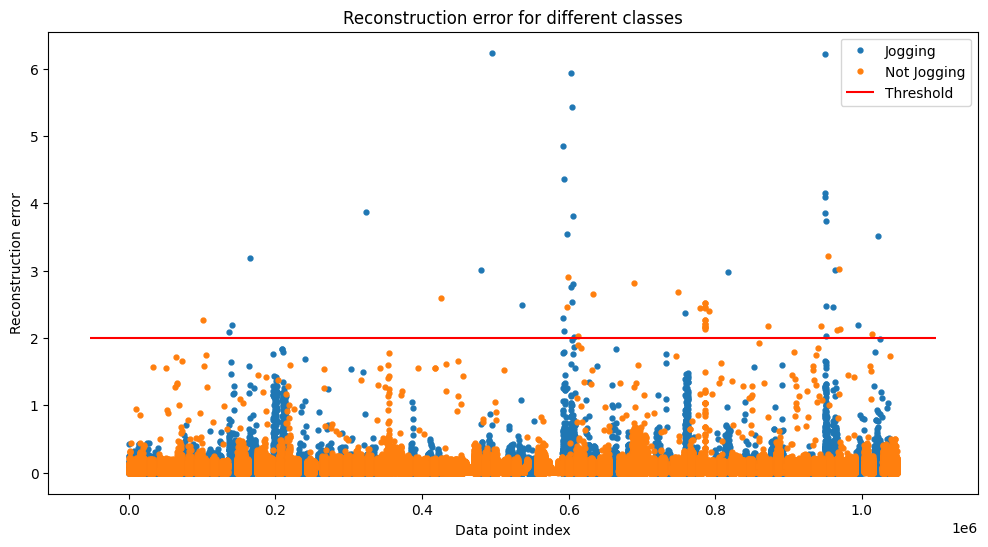

In [50]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(12, 6))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= LABELS[name]) # 0="Jogging", 1="Not Jogging"

# --- 중요! Threshold 값 설정 ---
# 이 값은 그래프를 보고 직접 조정해야 합니다.
# "Jogging"의 오류(파란색 점)보다는 높고, "Not Jogging"의 오류(주황색 점)보다는 낮은 적절한 선을 찾아야 합니다.
# 일단 예시 값으로 2.0을 설정합니다.
threshold = 2.0

ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

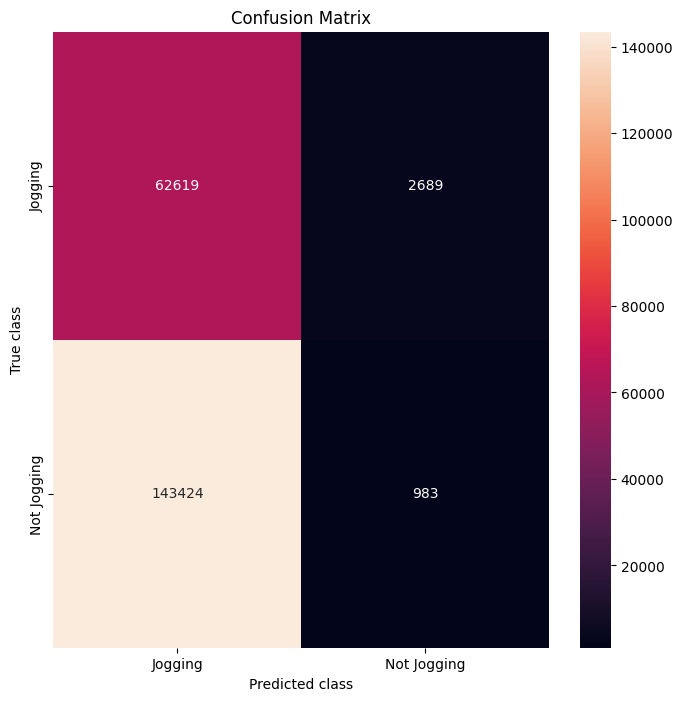


--- Classification Report ---
              precision    recall  f1-score   support

     Jogging       0.30      0.96      0.46     65308
 Not Jogging       0.27      0.01      0.01    144407

    accuracy                           0.30    209715
   macro avg       0.29      0.48      0.24    209715
weighted avg       0.28      0.30      0.15    209715



In [44]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion Matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Classification Report
print("\n--- Classification Report ---")
print(classification_report(error_df.true_class, y_pred, target_names=LABELS))